In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

# Time series specific
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from prophet import Prophet

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

# For UCI dataset
from ucimlrepo import fetch_ucirepo

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

class TimeSeriesDataset(Dataset):
    """Custom Dataset for time series data"""
    def __init__(self, data, sequence_length, target_col='global_active_power'):
        self.data = data
        self.sequence_length = sequence_length
        self.target_col = target_col
        
    def __len__(self):
        return len(self.data) - self.sequence_length
    
    def __getitem__(self, idx):
        # Get sequence of features
        x = self.data.iloc[idx:idx + self.sequence_length].values
        # Get target (next value)
        y = self.data[self.target_col].iloc[idx + self.sequence_length]
        
        return torch.FloatTensor(x), torch.FloatTensor([y])

In [6]:
class LSTMForecaster(nn.Module):
    """LSTM model for time series forecasting"""
    def __init__(self, input_size, hidden_size=64, num_layers=2, dropout=0.2):
        super(LSTMForecaster, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                           batch_first=True, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_output = lstm_out[:, -1, :]
        dropped = self.dropout(last_output)
        output = self.fc(dropped)
        return output

class GRUForecaster(nn.Module):
    """GRU model for time series forecasting"""
    def __init__(self, input_size, hidden_size=64, num_layers=2, dropout=0.2):
        super(GRUForecaster, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_size, hidden_size, num_layers, 
                         batch_first=True, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        gru_out, _ = self.gru(x)
        last_output = gru_out[:, -1, :]
        dropped = self.dropout(last_output)
        output = self.fc(dropped)
        return output

class TCNBlock(nn.Module):
    """Temporal Convolutional Network Block"""
    def __init__(self, in_channels, out_channels, kernel_size, dilation, dropout=0.2):
        super(TCNBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size,
                              dilation=dilation, padding=(kernel_size-1)*dilation)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)
        
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size,
                              dilation=dilation, padding=(kernel_size-1)*dilation)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)
        
        # Residual connection
        self.downsample = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else None
        
    def forward(self, x):
        residual = x
        
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.dropout1(out)
        
        out = self.conv2(out)
        out = self.relu2(out)
        out = self.dropout2(out)
        
        # Crop to match input size
        out = out[:, :, :x.size(2)]
        
        if self.downsample is not None:
            residual = self.downsample(residual)
            
        return out + residual

class TCN(nn.Module):
    """Temporal Convolutional Network"""
    def __init__(self, input_size, num_channels=[64, 64, 64], kernel_size=3, dropout=0.2):
        super(TCN, self).__init__()
        
        layers = []
        num_levels = len(num_channels)
        
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = input_size if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            
            layers.append(TCNBlock(in_channels, out_channels, kernel_size, dilation_size, dropout))
        
        self.network = nn.Sequential(*layers)
        self.fc = nn.Linear(num_channels[-1], 1)
        
    def forward(self, x):
        # x shape: (batch, seq_len, features)
        x = x.transpose(1, 2)  # (batch, features, seq_len)
        x = self.network(x)
        x = x[:, :, -1]  # Take last timestep
        return self.fc(x)

class LSTMAutoencoder(nn.Module):
    """LSTM Autoencoder for anomaly detection"""
    def __init__(self, input_size, hidden_size=64, num_layers=2):
        super(LSTMAutoencoder, self).__init__()
        
        # Encoder
        self.encoder_lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
        # Decoder
        self.decoder_lstm = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True)
        self.output_layer = nn.Linear(hidden_size, input_size)
        
    def forward(self, x):
        # Encoder
        encoded, (hidden, cell) = self.encoder_lstm(x)
        
        # Use the last encoded state to initialize decoder
        seq_len = x.size(1)
        decoded_input = encoded[:, -1:, :].repeat(1, seq_len, 1)
        
        # Decoder
        decoded, _ = self.decoder_lstm(decoded_input)
        output = self.output_layer(decoded)
        
        return output

class TransformerForecaster(nn.Module):
    """Transformer model for time series forecasting"""
    def __init__(self, input_size, d_model=64, nhead=8, num_layers=3, dropout=0.1):
        super(TransformerForecaster, self).__init__()
        
        self.input_projection = nn.Linear(input_size, d_model)
        self.pos_encoding = nn.Parameter(torch.randn(1000, d_model))
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dropout=dropout, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        self.fc = nn.Linear(d_model, 1)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        seq_len = x.size(1)
        
        # Project input to d_model dimension
        x = self.input_projection(x)
        
        # Add positional encoding
        x = x + self.pos_encoding[:seq_len, :].unsqueeze(0)
        
        # Transformer encoding
        x = self.transformer(x)
        
        # Take last timestep and predict
        x = self.dropout(x[:, -1, :])
        output = self.fc(x)
        
        return output


🔧 Using device: cuda
🚀 Starting Complete Energy Consumption Analysis...
📥 Loading UCI dataset...
✅ Dataset loaded. Shape: (2075259, 9)
📊 Columns: ['date', 'time', 'global_active_power', 'global_reactive_power', 'voltage', 'global_intensity', 'sub_metering_1', 'sub_metering_2', 'sub_metering_3']

📋 Dataset Metadata:
{'uci_id': 235, 'name': 'Individual Household Electric Power Consumption', 'repository_url': 'https://archive.ics.uci.edu/dataset/235/individual+household+electric+power+consumption', 'data_url': 'https://archive.ics.uci.edu/static/public/235/data.csv', 'abstract': 'Measurements of electric power consumption in one household with a one-minute sampling rate over a period of almost 4 years. Different electrical quantities and some sub-metering values are available.', 'area': 'Physics and Chemistry', 'tasks': ['Regression', 'Clustering'], 'characteristics': ['Multivariate', 'Time-Series'], 'num_instances': 2075259, 'num_features': 9, 'feature_types': ['Real'], 'demographics': [

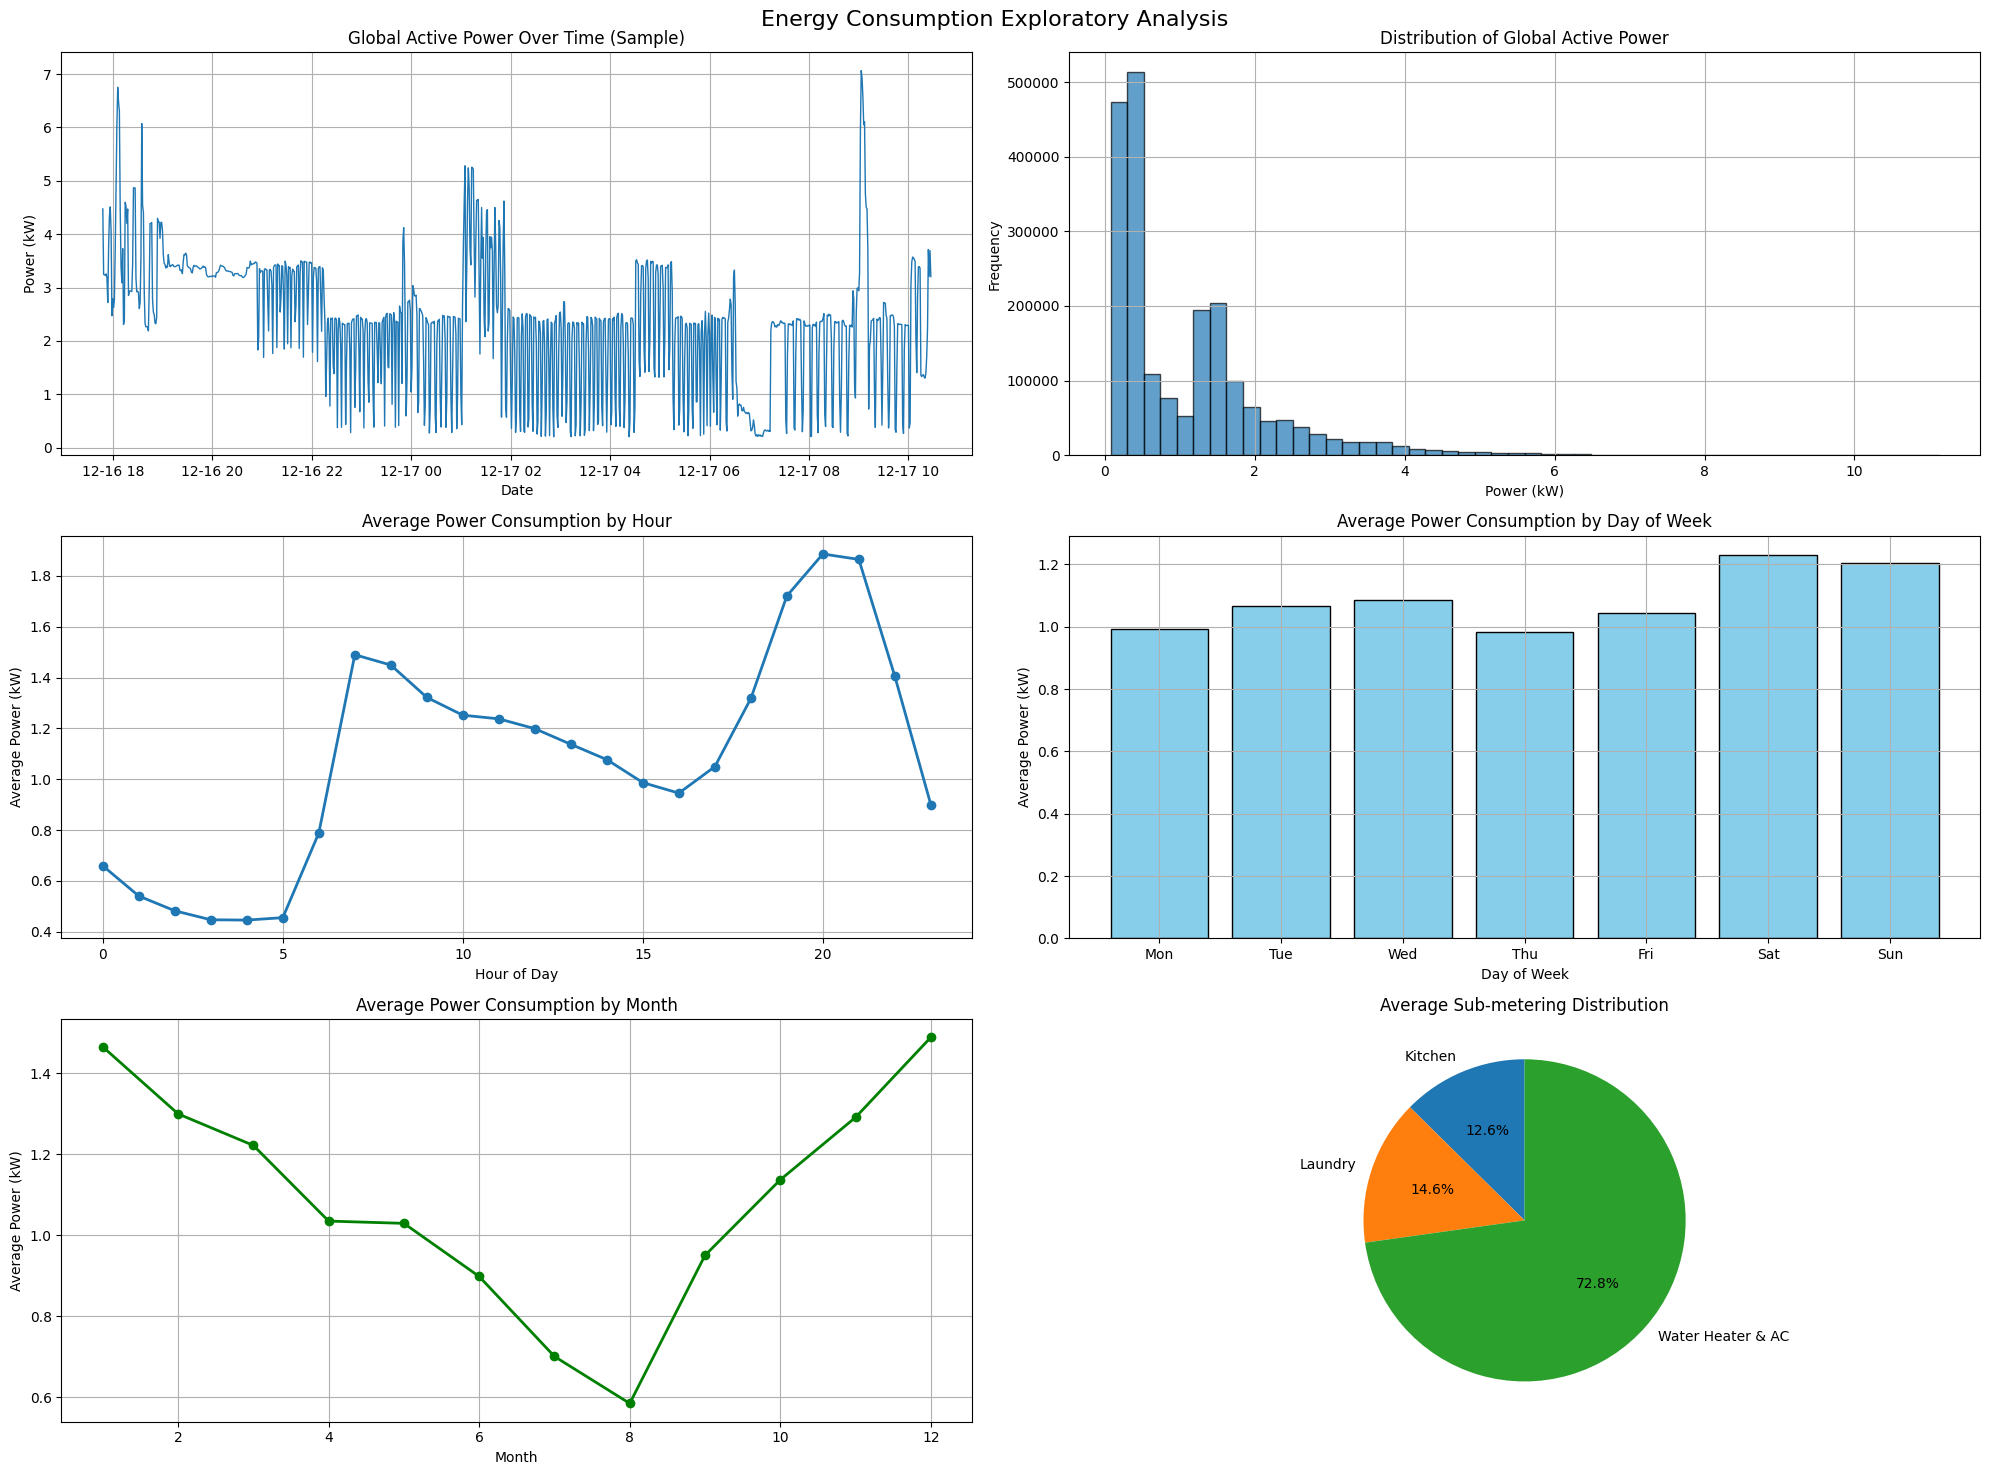


🔄 Performing seasonal decomposition...


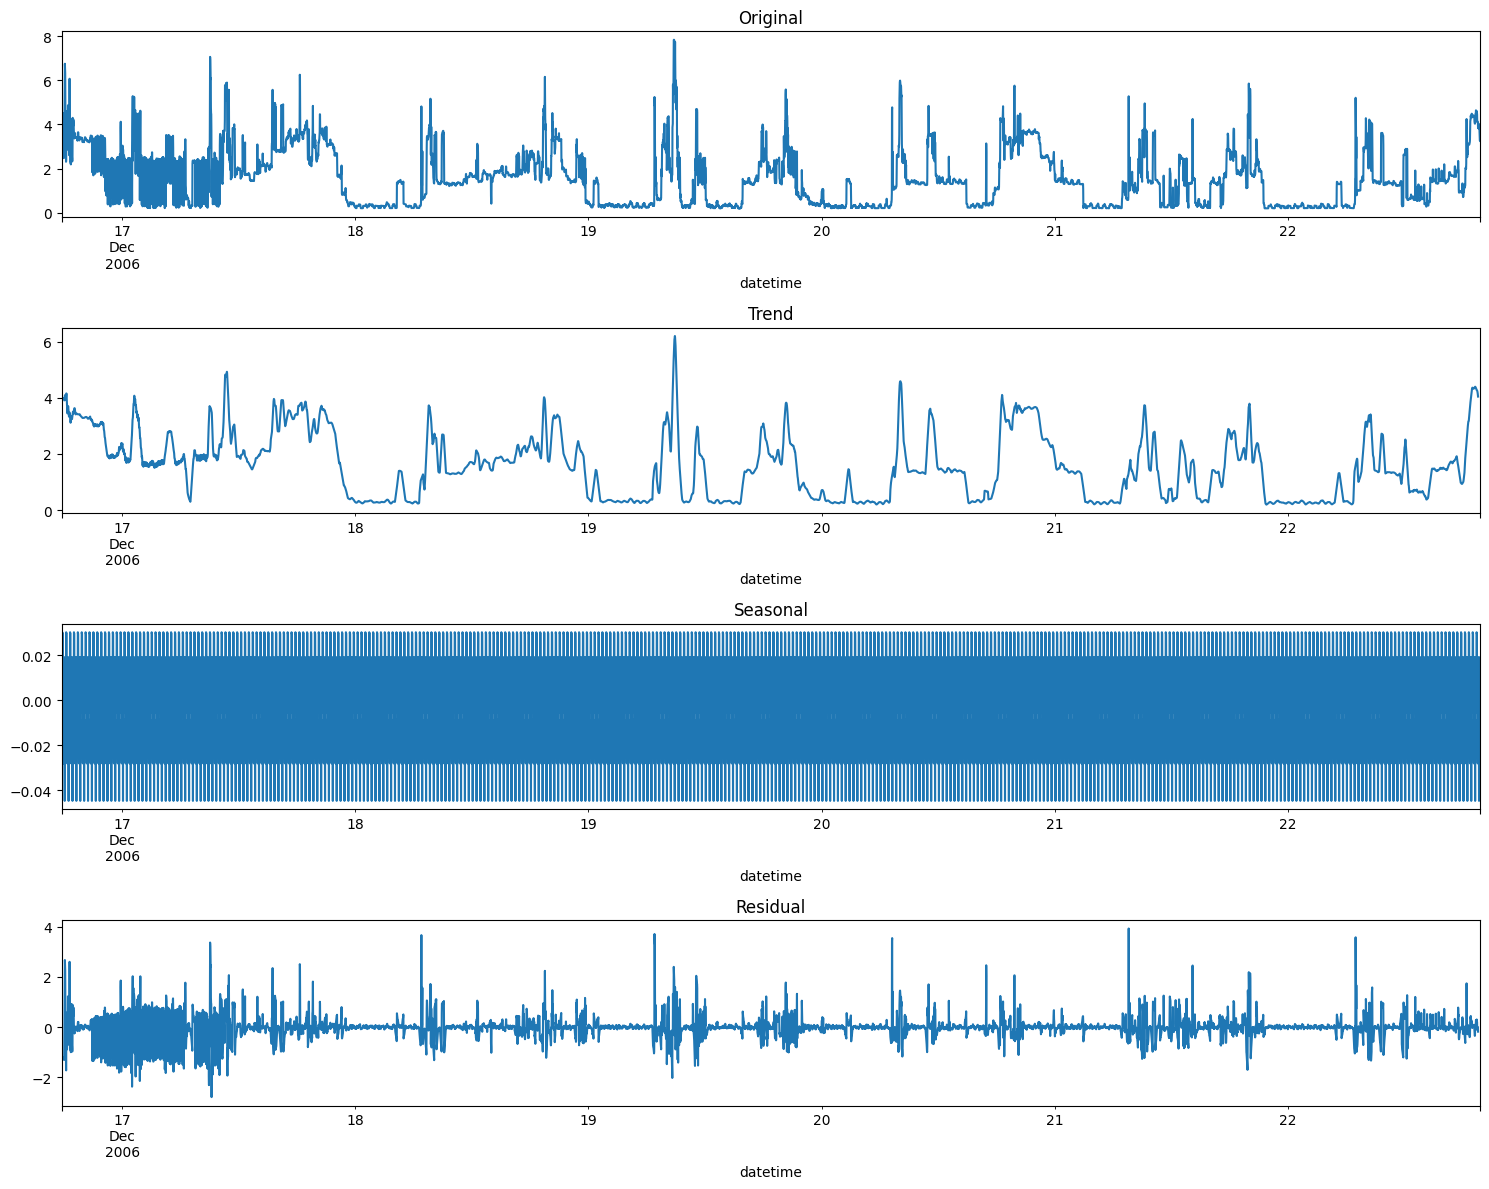


TRAINING FORECASTING MODELS

🧠 Training LSTM model...
Epoch 0, Train Loss: 0.0615, Val Loss: 0.0503


KeyboardInterrupt: 

In [13]:
class EnergyConsumptionAnalyzer:
    def __init__(self):
        """Initialize the Energy Consumption Analyzer"""
        self.data = None
        self.processed_data = None
        self.models = {}
        self.predictions = {}
        self.anomalies = {}
        self.scalers = {}
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"🔧 Using device: {self.device}")
    def load_data(self):
        """Load the UCI Individual Household Electric Power Consumption dataset"""
        print("📥 Loading UCI dataset...")
    
        try:
            # Fetch dataset
            dataset = fetch_ucirepo(id=235)
    
            # Get features and targets
            X = dataset.data.features
            y = dataset.data.targets if dataset.data.targets is not None else pd.DataFrame()
    
            # Combine X and y if y exists
            if not y.empty:
                self.data = pd.concat([X, y], axis=1)
            else:
                self.data = X.copy()
    
            # ✅ Convert column names to lowercase for consistency
            self.data.columns = [col.lower() for col in self.data.columns]
    
            print(f"✅ Dataset loaded. Shape: {self.data.shape}")
            print(f"📊 Columns: {list(self.data.columns)}")
    
            # Display metadata and variables
            print("\n📋 Dataset Metadata:")
            print(dataset.metadata)
            print("\n📊 Variable Information:")
            print(dataset.variables)
    
            return self.data
    
        except Exception as e:
            print(f"❌ Error loading dataset: {e}")
            print("📥 Creating synthetic dataset for demonstration...")
    
            # Create synthetic dataset
            dates = pd.date_range('2006-12-16', periods=10000, freq='H')
            np.random.seed(42)
    
            # Simulate realistic energy consumption patterns
            base_consumption = 2.0
            daily_pattern = np.sin(2 * np.pi * np.arange(10000) / 24) * 1.5
            weekly_pattern = np.sin(2 * np.pi * np.arange(10000) / (24 * 7)) * 0.5
            noise = np.random.normal(0, 0.3, 10000)
    
            self.data = pd.DataFrame({
                'global_active_power': base_consumption + daily_pattern + weekly_pattern + noise,
                'global_reactive_power': np.random.normal(0.12, 0.05, 10000),
                'voltage': np.random.normal(240, 5, 10000),
                'global_intensity': np.random.normal(9, 3, 10000),
                'sub_metering_1': np.random.exponential(1, 10000),
                'sub_metering_2': np.random.exponential(1, 10000),
                'sub_metering_3': np.random.exponential(2, 10000)
            }, index=dates)
    
            # Ensure positive values
            self.data = self.data.abs()
    
            print(f"✅ Synthetic dataset created. Shape: {self.data.shape}")
            return self.data

    def preprocess_data(self):
        """Preprocess the energy consumption data"""
        print("\n🔧 Preprocessing data...")
    
        # Replace '?' with NaN across entire dataframe
        self.data.replace('?', np.nan, inplace=True)
    
        # Convert relevant numeric columns to float
        numeric_cols = ['global_active_power', 'sub_metering_1', 'sub_metering_2', 'sub_metering_3']
        for col in numeric_cols:
            if col in self.data.columns:
                self.data[col] = pd.to_numeric(self.data[col], errors='coerce')
    
        # Handle missing values
        if self.data.isnull().sum().sum() > 0:
            print(f"Missing values before cleaning: {self.data.isnull().sum().sum()}")
            self.data = self.data.fillna(method='ffill').fillna(method='bfill')
            self.data = self.data.dropna()
    
        if not isinstance(self.data.index, pd.DatetimeIndex):
            if 'date' in self.data.columns and 'time' in self.data.columns:
                self.data['datetime'] = pd.to_datetime(
                    self.data['date'].astype(str) + ' ' + self.data['time'].astype(str),
                    errors='coerce'  # если там странные строки
                )
                if self.data['datetime'].isnull().all():
                    raise ValueError("❌ 'datetime' column could not be created. Check date/time formatting.")
                
                self.data.set_index('datetime', inplace=True)
                self.data.drop(['date', 'time'], axis=1, inplace=True)
            else:
                print(f"❌ 'date' and 'time' columns not found. Available columns: {self.data.columns.tolist()}")
                raise KeyError("Missing 'date' and 'time' columns to create datetime index.")
    
        # Create time-based features
        self.data['hour'] = self.data.index.hour
        self.data['day_of_week'] = self.data.index.dayofweek
        self.data['month'] = self.data.index.month
        self.data['quarter'] = self.data.index.quarter
        self.data['is_weekend'] = (self.data.index.dayofweek >= 5).astype(int)
    
        # Create cyclical features
        self.data['hour_sin'] = np.sin(2 * np.pi * self.data['hour'] / 24)
        self.data['hour_cos'] = np.cos(2 * np.pi * self.data['hour'] / 24)
        self.data['day_sin'] = np.sin(2 * np.pi * self.data['day_of_week'] / 7)
        self.data['day_cos'] = np.cos(2 * np.pi * self.data['day_of_week'] / 7)
        self.data['month_sin'] = np.sin(2 * np.pi * self.data['month'] / 12)
        self.data['month_cos'] = np.cos(2 * np.pi * self.data['month'] / 12)
    
        # Derived features
        if all(col in self.data.columns for col in ['sub_metering_1', 'sub_metering_2', 'sub_metering_3']):
            self.data['total_sub_metering'] = (
                self.data['sub_metering_1'] + 
                self.data['sub_metering_2'] + 
                self.data['sub_metering_3']
            )

        # Lag features
        target_col = 'global_active_power'
        if target_col in self.data.columns:
            for lag in [1, 2, 3, 6, 12, 24]:
                self.data[f'{target_col}_lag_{lag}'] = self.data[target_col].shift(lag)
    
            # Rolling statistics
            for window in [3, 6, 12, 24]:
                self.data[f'{target_col}_rolling_mean_{window}'] = self.data[target_col].rolling(window).mean()
                self.data[f'{target_col}_rolling_std_{window}'] = self.data[target_col].rolling(window).std()
    
        # Remove rows with NaNs introduced by lag/rolling
        self.data = self.data.dropna()
    
        print(f"✅ Data preprocessed. Final shape: {self.data.shape}")
        print(f"📅 Date range: {self.data.index.min()} to {self.data.index.max()}")
    
        self.processed_data = self.data.copy()

        
    def exploratory_analysis(self):
        """Perform exploratory data analysis"""
        print("\n📊 Performing exploratory analysis...")
        
        # Basic statistics
        print("\n📈 Basic Statistics:")
        print(self.data.describe())
        
        # Create comprehensive visualization
        fig, axes = plt.subplots(3, 2, figsize=(20, 15))
        fig.suptitle('Energy Consumption Exploratory Analysis', fontsize=16)
        
        # Time series plot
        sample_data = self.data.iloc[:1000]
        axes[0, 0].plot(sample_data.index, sample_data['global_active_power'], linewidth=1)
        axes[0, 0].set_title('Global Active Power Over Time (Sample)')
        axes[0, 0].set_xlabel('Date')
        axes[0, 0].set_ylabel('Power (kW)')
        axes[0, 0].grid(True)
        
        # Distribution
        axes[0, 1].hist(self.data['global_active_power'], bins=50, alpha=0.7, edgecolor='black')
        axes[0, 1].set_title('Distribution of Global Active Power')
        axes[0, 1].set_xlabel('Power (kW)')
        axes[0, 1].set_ylabel('Frequency')
        axes[0, 1].grid(True)
        
        # Hourly patterns
        hourly_avg = self.data.groupby('hour')['global_active_power'].mean()
        axes[1, 0].plot(hourly_avg.index, hourly_avg.values, marker='o', linewidth=2)
        axes[1, 0].set_title('Average Power Consumption by Hour')
        axes[1, 0].set_xlabel('Hour of Day')
        axes[1, 0].set_ylabel('Average Power (kW)')
        axes[1, 0].grid(True)
        
        # Weekly patterns
        weekly_avg = self.data.groupby('day_of_week')['global_active_power'].mean()
        day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
        axes[1, 1].bar(range(7), weekly_avg.values, color='skyblue', edgecolor='black')
        axes[1, 1].set_title('Average Power Consumption by Day of Week')
        axes[1, 1].set_xlabel('Day of Week')
        axes[1, 1].set_ylabel('Average Power (kW)')
        axes[1, 1].set_xticks(range(7))
        axes[1, 1].set_xticklabels(day_names)
        axes[1, 1].grid(True)
        
        # Monthly patterns
        monthly_avg = self.data.groupby('month')['global_active_power'].mean()
        axes[2, 0].plot(monthly_avg.index, monthly_avg.values, marker='o', linewidth=2, color='green')
        axes[2, 0].set_title('Average Power Consumption by Month')
        axes[2, 0].set_xlabel('Month')
        axes[2, 0].set_ylabel('Average Power (kW)')
        axes[2, 0].grid(True)
        
        # Sub-metering analysis
        if all(col in self.data.columns for col in ['sub_metering_1', 'sub_metering_2', 'sub_metering_3']):
            sub_cols = ['sub_metering_1', 'sub_metering_2', 'sub_metering_3']
            sub_avg = [self.data[col].mean() for col in sub_cols]
            sub_labels = ['Kitchen', 'Laundry', 'Water Heater & AC']
            
            axes[2, 1].pie(sub_avg, labels=sub_labels, autopct='%1.1f%%', startangle=90)
            axes[2, 1].set_title('Average Sub-metering Distribution')
        else:
            axes[2, 1].text(0.5, 0.5, 'Sub-metering data\nnot available', 
                           ha='center', va='center', transform=axes[2, 1].transAxes)
        
        plt.tight_layout()
        plt.show()
        
        # Seasonal decomposition
        if len(self.data) > 1000:
            print("\n🔄 Performing seasonal decomposition...")
            try:
                decomposition = seasonal_decompose(
                    self.data['global_active_power'].iloc[:min(8760, len(self.data))],
                    model='additive', 
                    period=24
                )
                
                fig, axes = plt.subplots(4, 1, figsize=(15, 12))
                decomposition.observed.plot(ax=axes[0], title='Original')
                decomposition.trend.plot(ax=axes[1], title='Trend')
                decomposition.seasonal.plot(ax=axes[2], title='Seasonal')
                decomposition.resid.plot(ax=axes[3], title='Residual')
                plt.tight_layout()
                plt.show()
            except Exception as e:
                print(f"Could not perform decomposition: {e}")

    def prepare_sequences(self, data, sequence_length=24, target_col='global_active_power'):
        """Prepare sequences for time series modeling"""
        
        # Select features (exclude target from features)
        feature_cols = [col for col in data.columns if col != target_col]
        
        # Scale features and target separately
        feature_scaler = StandardScaler()
        target_scaler = StandardScaler()
        
        scaled_features = feature_scaler.fit_transform(data[feature_cols])
        scaled_target = target_scaler.fit_transform(data[[target_col]])
        
        # Combine scaled features and target
        scaled_data = pd.DataFrame(
            np.hstack([scaled_features, scaled_target]),
            columns=feature_cols + [target_col],
            index=data.index
        )
        
        # Store scalers
        self.scalers['feature_scaler'] = feature_scaler
        self.scalers['target_scaler'] = target_scaler
        
        return scaled_data, feature_cols

    def train_pytorch_model(self, model_type='lstm', sequence_length=24, epochs=50, batch_size=32):
        """Train PyTorch forecasting model"""
        print(f"\n🧠 Training {model_type.upper()} model...")
        
        # Prepare data
        scaled_data, feature_cols = self.prepare_sequences(self.processed_data, sequence_length)
        
        # Create dataset
        dataset = TimeSeriesDataset(scaled_data, sequence_length)
        
        # Split data
        train_size = int(0.8 * len(dataset))
        val_size = len(dataset) - train_size
        
        train_dataset, val_dataset = torch.utils.data.random_split(
            dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42)
        )
        
        # Create data loaders
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        
        # Initialize model based on type
        input_size = len(feature_cols) + 1  # +1 for target column
        
        if model_type == 'lstm':
            model = LSTMForecaster(input_size=input_size).to(self.device)
        elif model_type == 'gru':
            model = GRUForecaster(input_size=input_size).to(self.device)
        elif model_type == 'tcn':
            model = TCN(input_size=input_size).to(self.device)
        elif model_type == 'transformer':
            model = TransformerForecaster(input_size=input_size).to(self.device)
        else:
            raise ValueError(f"Unknown model type: {model_type}")
        
        # Loss and optimizer
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)
        
        # Training loop
        train_losses = []
        val_losses = []
        best_val_loss = float('inf')
        patience_counter = 0
        
        for epoch in range(epochs):
            # Training
            model.train()
            train_loss = 0
            for batch_x, batch_y in train_loader:
                batch_x, batch_y = batch_x.to(self.device), batch_y.to(self.device)
                
                optimizer.zero_grad()
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                loss.backward()
                
                # Gradient clipping
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                
                optimizer.step()
                train_loss += loss.item()
            
            # Validation
            model.eval()
            val_loss = 0
            with torch.no_grad():
                for batch_x, batch_y in val_loader:
                    batch_x, batch_y = batch_x.to(self.device), batch_y.to(self.device)
                    outputs = model(batch_x)
                    val_loss += criterion(outputs, batch_y).item()
            
            train_loss /= len(train_loader)
            val_loss /= len(val_loader)
            
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            
            scheduler.step(val_loss)
            
            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                # Save best model
                torch.save(model.state_dict(), f'best_{model_type}_model.pth')
            else:
                patience_counter += 1
            
            if epoch % 10 == 0:
                print(f'Epoch {epoch}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
            
            if patience_counter >= 10:  # Early stopping
                print(f"Early stopping at epoch {epoch}")
                break
        
        # Load best model
        model.load_state_dict(torch.load(f'best_{model_type}_model.pth'))
        self.models[model_type] = model
        
        # Plot training history
        plt.figure(figsize=(10, 6))
        plt.plot(train_losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.title(f'{model_type.upper()} Training History')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.show()
        
        return model

    def train_autoencoder_anomaly_detector(self, sequence_length=24, epochs=50, batch_size=32):
        """Train LSTM Autoencoder for anomaly detection"""
        print(f"\n🚨 Training Autoencoder for anomaly detection...")
        
        # Prepare data for autoencoder (use all features except target)
        feature_cols = [col for col in self.processed_data.columns 
                       if col not in ['global_active_power'] and 
                       not col.startswith('global_active_power_')]
        
        scaler = StandardScaler()
        scaled_features = scaler.fit_transform(self.processed_data[feature_cols])
        scaled_data = pd.DataFrame(scaled_features, columns=feature_cols, 
                                 index=self.processed_data.index)
        
        # Create sequences for autoencoder
        sequences = []
        for i in range(len(scaled_data) - sequence_length + 1):
            sequences.append(scaled_data.iloc[i:i + sequence_length].values)
        
        sequences = np.array(sequences)
        sequences_tensor = torch.FloatTensor(sequences)
        
        # Create data loader
        dataset = torch.utils.data.TensorDataset(sequences_tensor, sequences_tensor)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        
        # Initialize autoencoder
        input_size = len(feature_cols)
        autoencoder = LSTMAutoencoder(input_size=input_size).to(self.device)
        
        # Loss and optimizer
        criterion = nn.MSELoss()
        optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
        
        # Training loop
        losses = []
        
        for epoch in range(epochs):
            autoencoder.train()
            epoch_loss = 0
            
            for batch_x, batch_y in dataloader:
                batch_x = batch_x.to(self.device)
                
                optimizer.zero_grad()
                reconstructed = autoencoder(batch_x)
                loss = criterion(reconstructed, batch_x)
                loss.backward()
                optimizer.step()
                
                epoch_loss += loss.item()
            
            avg_loss = epoch_loss / len(dataloader)
            losses.append(avg_loss)
            
            if epoch % 10 == 0:
                print(f'Epoch {epoch}, Loss: {avg_loss:.4f}')
        
        self.models['autoencoder'] = autoencoder
        self.scalers['autoencoder_scaler'] = scaler
        
        # Calculate reconstruction errors for threshold setting
        autoencoder.eval()
        reconstruction_errors = []
        
        with torch.no_grad():
            for i in range(0, len(sequences_tensor), batch_size):
                batch = sequences_tensor[i:i + batch_size].to(self.device)
                reconstructed = autoencoder(batch)
                errors = torch.mean((batch - reconstructed) ** 2, dim=(1, 2))
                reconstruction_errors.extend(errors.cpu().numpy())
        
        # Set threshold as 95th percentile of reconstruction errors
        threshold = np.percentile(reconstruction_errors, 95)
        self.anomaly_threshold = threshold
        
        print(f"✅ Autoencoder trained. Anomaly threshold: {threshold:.4f}")
        
        # Plot training history
        plt.figure(figsize=(10, 6))
        plt.plot(losses)
        plt.title('Autoencoder Training History')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid(True)
        plt.show()
        
        return autoencoder

    def detect_anomalies(self, method='isolation_forest'):
        """Detect anomalies using various methods"""
        print(f"\n🚨 Detecting anomalies using {method}...")
        
        if method == 'isolation_forest':
            # Isolation Forest
            features = self.processed_data.select_dtypes(include=[np.number])
            scaler = StandardScaler()
            scaled_features = scaler.fit_transform(features)
            
            iso_forest = IsolationForest(contamination=0.05, random_state=42)
            anomalies = iso_forest.fit_predict(scaled_features)
            
            self.anomalies['isolation_forest'] = (anomalies == -1)
            
        elif method == 'one_class_svm':
            # One-Class SVM
            features = self.processed_data.select_dtypes(include=[np.number])
            scaler = StandardScaler()
            scaled_features = scaler.fit_transform(features)
            
            oc_svm = OneClassSVM(nu=0.05)
            anomalies = oc_svm.fit_predict(scaled_features)
            
            self.anomalies['one_class_svm'] = (anomalies == -1)
            
        elif method == 'statistical':
            # Statistical method using Z-score
            target_col = 'global_active_power'
            z_scores = np.abs((self.processed_data[target_col] - 
                             self.processed_data[target_col].mean()) / 
                             self.processed_data[target_col].std())
            
            self.anomalies['statistical'] = (z_scores > 3)
            
        elif method == 'autoencoder' and 'autoencoder' in self.models:
            # Autoencoder-based anomaly detection
            feature_cols = [col for col in self.processed_data.columns 
                           if col not in ['global_active_power'] and 
                           not col.startswith('global_active_power_')]
            
            scaler = self.scalers['autoencoder_scaler']
            scaled_features = scaler.transform(self.processed_data[feature_cols])
            
            autoencoder = self.models['autoencoder']
            sequence_length = 24
            
            anomalies = []
            autoencoder.eval()
            
            with torch.no_grad():
                for i in range(len(scaled_features) - sequence_length + 1):
                    seq = scaled_features[i:i + sequence_length]
                    seq_tensor = torch.FloatTensor(seq).unsqueeze(0).to(self.device)
                    
                    reconstructed = autoencoder(seq_tensor)
                    error = torch.mean((seq_tensor - reconstructed) ** 2).item()
                    
                    anomalies.append(error > self.anomaly_threshold)
            
            # Pad with False for the first sequence_length-1 points
            full_anomalies = [False] * (sequence_length - 1) + anomalies
            self.anomalies['autoencoder'] = np.array(full_anomalies)
        
        # Visualize anomalies
        self.visualize_anomalies(method)

    def visualize_anomalies(self, method):
        """Visualize detected anomalies"""
        if method not in self.anomalies:
            print(f"No anomalies detected using {method}")
            return
        
        anomaly_indices = self.anomalies[method]
        anomaly_count = np.sum(anomaly_indices)
        
        print(f"🚨 Found {anomaly_count} anomalies ({anomaly_count/len(anomaly_indices)*100:.2f}%)")
        
        # Plot time series with anomalies highlighted
        plt.figure(figsize=(15, 8))
        
        # Plot normal points
        normal_data = self.processed_data[~anomaly_indices]
        plt.scatter(normal_data.index, normal_data['global_active_power'], 
                   c='blue', s=1, alpha=0.6, label='Normal')
        
        # Plot anomalies
        anomaly_data = self.processed_data[anomaly_indices]
        if len(anomaly_data) > 0:
            plt.scatter(anomaly_data.index, anomaly_data['global_active_power'], 
                       c='red', s=10, alpha=0.8, label='Anomaly')
        
        plt.title(f'Anomaly Detection using {method.replace("_", " ").title()}')
        plt.xlabel('Date')
        plt.ylabel('Global Active Power (kW)')
        plt.legend()
        plt.grid(True)
        plt.show()

    def train_prophet_model(self):
        """Train Prophet model for forecasting"""
        print("\n🔮 Training Prophet model...")
        
        try:
            # Prepare data for Prophet
            prophet_data = self.processed_data[['global_active_power']].reset_index()
            prophet_data.columns = ['ds', 'y']
            
            # Initialize and train Prophet model
            model = Prophet(
                daily_seasonality=True,
                weekly_seasonality=True,
                yearly_seasonality=True,
                changepoint_prior_scale=0.05
            )
            
            model.fit(prophet_data)
            self.models['prophet'] = model
            
            # Make future predictions
            future = model.make_future_dataframe(periods=168, freq='H')  # 1 week ahead
            forecast = model.predict(future)
            
            self.predictions['prophet'] = forecast
            
            # Plot forecast
            fig = model.plot(forecast)
            plt.title('Prophet Forecast')
            plt.show()
            
            # Plot components
            fig = model.plot_components(forecast)
            plt.show()
            
            print("✅ Prophet model trained successfully")
            
        except Exception as e:
            print(f"❌ Error training Prophet model: {e}")

    def evaluate_models(self, test_size=0.2):
        """Evaluate all trained models"""
        print("\n📊 Evaluating models...")
        
        # Prepare test data
        target_col = 'global_active_power'
        test_start = int(len(self.processed_data) * (1 - test_size))
        test_data = self.processed_data.iloc[test_start:]
        
        results = {}
        
        # Evaluate PyTorch models
        for model_name in ['lstm', 'gru', 'tcn', 'transformer']:
            if model_name in self.models:
                try:
                    # Prepare test sequences
                    scaled_data, feature_cols = self.prepare_sequences(self.processed_data, 24)
                    test_dataset = TimeSeriesDataset(scaled_data.iloc[test_start:], 24)
                    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
                    
                    model = self.models[model_name]
                    model.eval()
                    
                    predictions = []
                    actuals = []
                    
                    with torch.no_grad():
                        for batch_x, batch_y in test_loader:
                            batch_x = batch_x.to(self.device)
                            outputs = model(batch_x)
                            predictions.extend(outputs.cpu().numpy().flatten())
                            actuals.extend(batch_y.numpy().flatten())
                    
                    # Inverse transform predictions
                    predictions = np.array(predictions).reshape(-1, 1)
                    actuals = np.array(actuals).reshape(-1, 1)
                    
                    predictions = self.scalers['target_scaler'].inverse_transform(predictions).flatten()
                    actuals = self.scalers['target_scaler'].inverse_transform(actuals).flatten()
                    
                    # Calculate metrics
                    mse = mean_squared_error(actuals, predictions)
                    mae = mean_absolute_error(actuals, predictions)
                    rmse = np.sqrt(mse)
                    mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100
                    
                    results[model_name] = {
                        'MSE': mse,
                        'MAE': mae,
                        'RMSE': rmse,
                        'MAPE': mape
                    }
                    
                except Exception as e:
                    print(f"Error evaluating {model_name}: {e}")
        
        # Display results
        if results:
            results_df = pd.DataFrame(results).T
            print("\n📊 Model Evaluation Results:")
            print(results_df.round(4))
            
            # Plot results
            fig, axes = plt.subplots(2, 2, figsize=(15, 10))
            
            metrics = ['MSE', 'MAE', 'RMSE', 'MAPE']
            for i, metric in enumerate(metrics):
                ax = axes[i//2, i%2]
                results_df[metric].plot(kind='bar', ax=ax)
                ax.set_title(f'{metric} by Model')
                ax.set_ylabel(metric)
                ax.tick_params(axis='x', rotation=45)
            
            plt.tight_layout()
            plt.show()

    def predict_future(self, model_name='lstm', steps=24):
        """Make future predictions"""
        if model_name not in self.models:
            print(f"Model {model_name} not trained yet")
            return None
        
        print(f"\n🔮 Making {steps} step predictions using {model_name}...")
        
        model = self.models[model_name]
        model.eval()
        
        # Get last sequence from processed data
        scaled_data, feature_cols = self.prepare_sequences(self.processed_data, 24)
        last_sequence = scaled_data.iloc[-24:].values
        
        predictions = []
        current_sequence = torch.FloatTensor(last_sequence).unsqueeze(0).to(self.device)
        
        with torch.no_grad():
            for _ in range(steps):
                pred = model(current_sequence)
                predictions.append(pred.cpu().item())
                
                # Update sequence for next prediction
                # For simplicity, we'll just append the prediction and remove the first element
                new_row = current_sequence[0, -1, :].clone()
                new_row[-1] = pred.item()  # Update target value
                
                current_sequence = torch.cat([
                    current_sequence[:, 1:, :],
                    new_row.unsqueeze(0).unsqueeze(0)
                ], dim=1)
        
        # Inverse transform predictions
        predictions = np.array(predictions).reshape(-1, 1)
        predictions = self.scalers['target_scaler'].inverse_transform(predictions).flatten()
        
        # Create future dates
        last_date = self.processed_data.index[-1]
        future_dates = pd.date_range(start=last_date + pd.Timedelta(hours=1), 
                                   periods=steps, freq='H')
        
        # Plot predictions
        plt.figure(figsize=(15, 8))
        
        # Plot recent history
        recent_data = self.processed_data['global_active_power'].iloc[-168:]  # Last week
        plt.plot(recent_data.index, recent_data.values, label='Historical', color='blue')
        
        # Plot predictions
        plt.plot(future_dates, predictions, label='Prediction', color='red', linestyle='--')
        
        plt.title(f'Future Predictions using {model_name.upper()}')
        plt.xlabel('Date')
        plt.ylabel('Global Active Power (kW)')
        plt.legend()
        plt.grid(True)
        plt.show()
        
        return predictions, future_dates

    def run_complete_analysis(self):
        """Run the complete analysis pipeline"""
        print("🚀 Starting Complete Energy Consumption Analysis...")
        
        # 3. Train forecasting models
        print("\n" + "="*50)
        print("TRAINING FORECASTING MODELS")
        print("="*50)
        
        self.train_pytorch_model('lstm', epochs=30)
        self.train_pytorch_model('gru', epochs=30)
        self.train_pytorch_model('tcn', epochs=30)
        self.train_prophet_model()
        
        # 4. Train anomaly detection
        print("\n" + "="*50)
        print("TRAINING ANOMALY DETECTION MODELS")
        print("="*50)
        
        self.train_autoencoder_anomaly_detector(epochs=30)
        
        # 5. Detect anomalies using different methods
        self.detect_anomalies('isolation_forest')
        self.detect_anomalies('statistical')
        self.detect_anomalies('autoencoder')
        
        # 6. Evaluate models
        self.evaluate_models()
        
        # 7. Make future predictions
        print("\n" + "="*50)
        print("MAKING FUTURE PREDICTIONS")
        print("="*50)
        
        self.predict_future('lstm', steps=48)  # 2 days ahead
        
        print("\n✅ Complete analysis finished!")

# Example usage
if __name__ == "__main__":
    # Initialize analyzer
    analyzer = EnergyConsumptionAnalyzer()
    
    # Run complete analysis
    analyzer.run_complete_analysis()